In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
import os
import seaborn as sns

In [2]:
PDB_BIOCHEM = os.getenv("PDB_BIOCHEM")


df = pd.read_csv(PDB_BIOCHEM)

## Bond length

In [3]:
from scipy import stats

In [4]:
cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
# Exclude outliers  with more than 4 sstd dev from mean
l_df = df[cond1 & cond2 & cond3]
cond4 = (stats.zscore(l_df["bond_length"])<4)
bond_l = l_df[cond4]["bond_length"].to_numpy()
bond_mean = np.mean(bond_l)
bond_std = np.std(bond_l)
print(f"Mean is : {round(np.mean(bond_l), 3)}, stdev is: {round(np.std(bond_l), 3)}")

Mean is : 1.328, stdev is: 0.082


In [5]:
ex = 2.25
print(f"Z-score for {ex} is {(ex - np.mean(bond_l))/np.std(bond_l)}")

Z-score for 2.25 is 11.262747968480294


In [9]:
cond1 = (df["Is bonded"])
cond2 = (df["Bad rotamer"])
bond_l = df[cond1 & cond2]["bond_length"].to_numpy()
print(f"Mean is : {np.mean(bond_l)}, stdev is: {np.std(bond_l)}")

Mean is : 2.9681124000000003, stdev is: 0.2393757203171318


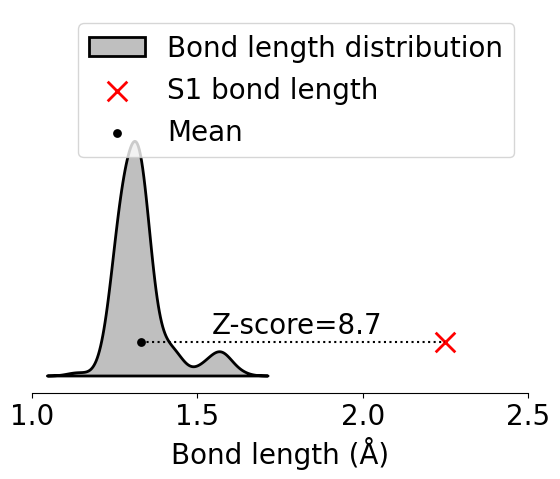

In [44]:
fig, ax = plt.subplots()

cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
plot_df = df[cond1 & cond2 & cond3]
cond4 = (stats.zscore(plot_df["bond_length"])<4)
plot_df = plot_df[cond4]

#
sns.kdeplot(plot_df, x="bond_length", label="Bond length distribution", ax=ax, 
    color="Black", lw=2, fill=True)
sns.scatterplot(y=[1], x=[2.25], marker="x", s=200, label="S1 bond length", ax=ax, color="red", lw=2)
sns.scatterplot(y=[1], x=bond_mean, s=40, label="Mean", ax=ax, color="black", lw=0)
sns.despine(ax=ax, offset=10)
ax.hlines(y=1, xmin=bond_mean, xmax=2.25, colors='black', linestyles='dotted')
ax.text(1.8, 1.1, "Z-score=8.7", ha='center', va='bottom', fontsize=20)

ax.set_xlim([1,2.5])
ax.set_ylim([-.1,11])
ax.set_xlabel("Bond length (Å)", fontsize=20)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ylabel("")

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

ax.legend(prop={'size':20}, loc="upper right")

plt.savefig("./output/bl.png", dpi=300, transparent=True, bbox_inches="tight")

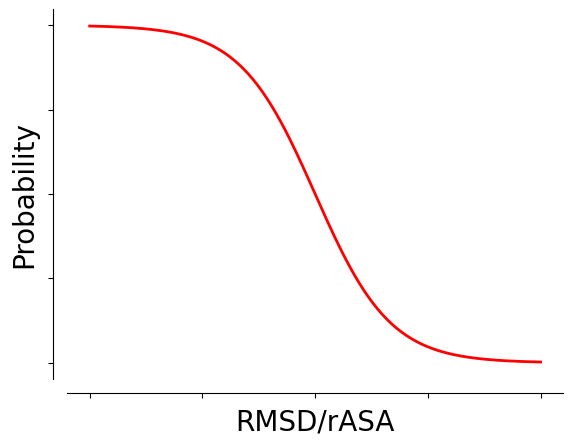

In [16]:
# Generate data points
x = np.linspace(-6, 6, 200)
y = 1 / (1 + np.exp(x))

fig, ax = plt.subplots()
ax.plot(x, y, 'r-', linewidth=2)

# Customize labels and appearance
ax.set_xlabel('RMSD/rASA', fontsize=20)
ax.set_ylabel('Probability', fontsize=20)

ax.set_xticks([-6, -3, 0, 3, 6], [])
ax.set_yticks([0,.25, .5, .75, 1], [])

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

sns.despine(ax=ax, offset=10)

plt.savefig("output/curve.png", dpi=300, bbox_inches="tight", transparent=True)

## Angles

### One model for each angle pair (easier to represent and interpretate)

In [8]:
# Create a unique KDE model using all angles for the CnaA/B like bonds
cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])

angle_pairs = [["phi", "psi"], ["omega", "psi"], ["omega", "phi"]]
bond_types = ["CnaA-like", "CnaB-like"]

data = {b: {"_".join(p): {} for p in angle_pairs} for b in bond_types}

for angle_pair in angle_pairs:
    for bond_type in bond_types:
        
        angles = df[cond1 & cond2 & cond3 & (df["Isopeptide type (see notes)"]==bond_type)][[f"pseudo_{angle_pair[0]}", f"pseudo_{angle_pair[1]}"]].to_numpy()
        kde = KernelDensity(bandwidth=10).fit(angles)
        log_densities_high_quality = kde.score_samples(angles)
        threshold = round(np.percentile(log_densities_high_quality, 5), 3)
        data[bond_type]["_".join(angle_pair)]["kde"] = kde
        data[bond_type]["_".join(angle_pair)]["threshold"] = threshold


In [10]:
import joblib
for bond_type in data.keys():
    for bond_pair in data[bond_type].keys():
        joblib.dump(data[bond_type][bond_pair]["kde"], f"output/{bond_type}_{bond_pair}.pkl")

{'CnaA-like': {'phi_psi': {'kde': KernelDensity(bandwidth=10),
   'threshold': -10.503},
  'omega_psi': {'kde': KernelDensity(bandwidth=10), 'threshold': -10.498},
  'omega_phi': {'kde': KernelDensity(bandwidth=10), 'threshold': -10.503}},
 'CnaB-like': {'phi_psi': {'kde': KernelDensity(bandwidth=10),
   'threshold': -10.663},
  'omega_psi': {'kde': KernelDensity(bandwidth=10), 'threshold': -10.757},
  'omega_phi': {'kde': KernelDensity(bandwidth=10), 'threshold': -10.849}}}

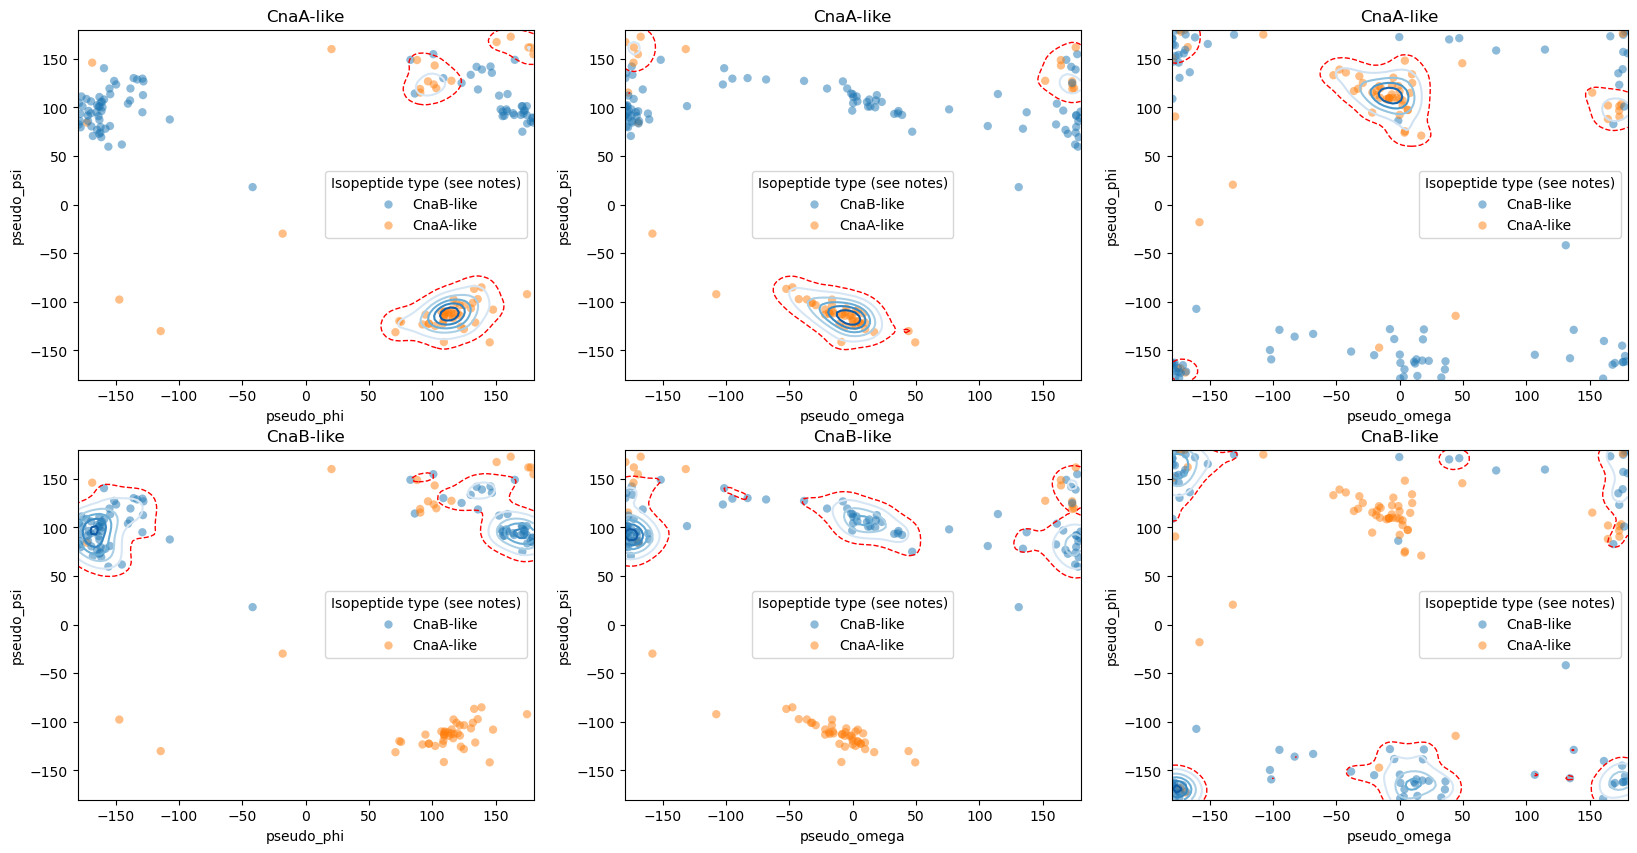

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [110]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10))

# Create grid points
x = np.linspace(-180, 180, 100)
y = np.linspace(-180, 180, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (df["Isopeptide type (see notes)"]!="Mutant")

for row_i, bond_type in enumerate(data.keys()):
    for col_i, angle_pair in enumerate(data[bond_type].keys()):
        ax = axs[row_i, col_i]
        kde = data[bond_type][angle_pair]["kde"]
        threshold = data[bond_type][angle_pair]["threshold"]

        # Evaluate KDE on the grid
        density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

        # Plot the KDE contours
        plt.figure(figsize=(8, 6))
        ax.contour(X, Y, density, levels=5, cmap="Blues")

        # Plot border 
        ax.contour(x, y, density, levels=[np.exp(threshold)], colors="red", linewidths=1, linestyles="--")

        # Overlay scatter plot
        sns.scatterplot(
            data=df[cond1 & cond2 & cond3],
            x=f"pseudo_{angle_pair.split('_')[0]}",
            y=f"pseudo_{angle_pair.split('_')[1]}", 
            hue="Isopeptide type (see notes)",
        ax=ax, lw=0, alpha=.5)

        ax.set_title(bond_type)

/tmp/ipykernel_2839527/1978238428.py:14: UserWarning: linewidths is ignored by contourf
  ax.contourf(X, Y, density, levels=10, cmap="Grays", linewidths=2)


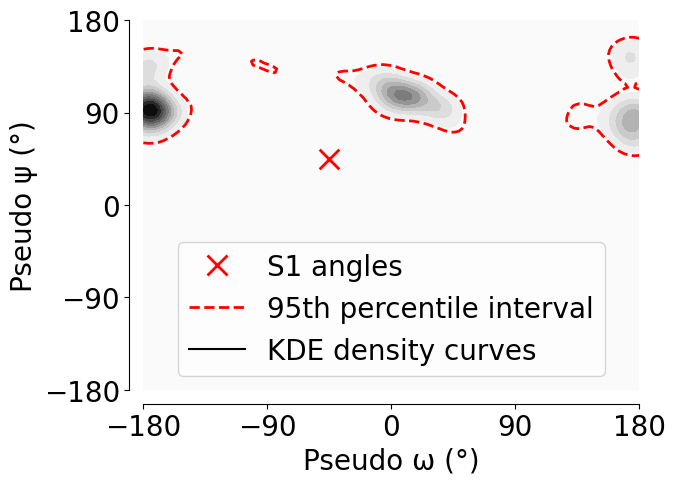

<Figure size 800x600 with 0 Axes>

In [244]:
fig, ax = plt.subplots()

bond_type = "CnaB-like"
angle_pair = "omega_psi"

kde = data[bond_type][angle_pair]["kde"]
threshold = data[bond_type][angle_pair]["threshold"]

# Evaluate KDE on the grid
density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

# Plot the KDE contours
plt.figure(figsize=(8, 6))
ax.contourf(X, Y, density, levels=10, cmap="Grays", linewidths=2)

# Plot border 
ax.contour(x, y, density, levels=[np.exp(threshold)], colors="red", linewidths=2, linestyles="--")

#ax.plot([-46, -10], [45,87], color='black', linestyle='dotted', zorder=1)
sns.scatterplot(x=[-45], y=[45], ax=ax, color="red", s=200, marker="x", lw=2)
#ax.text(-45, 10, "KDE likelihood=-35", ha='center', va='bottom', fontsize=20)

ax.legend(handles=[
    plt.Line2D([], [], color='red', marker='x', linestyle='', label='S1 angles', ms=15, markeredgewidth=2),
    plt.Line2D([], [], color='red', linestyle='--', lw=2, label='95th percentile interval'),
    plt.Line2D([], [], color='black', label='KDE density curves')
], loc="lower center", prop={'size': 20})

ax.set_ylim([-180,180])
ax.set_xlabel("Pseudo ω (°)", fontsize=20)
ax.set_ylabel("Pseudo ψ (°)", fontsize=20)
ax.set_xticks([-180, -90, 0, 90, 180])
ax.set_yticks([-180, -90, 0, 90, 180])
sns.despine(ax=ax, offset=10)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

fig.savefig("output/a.png", dpi=300, transparent=True, bbox_inches="tight")

### Unique model (difficult to represent and interpreate)

In [169]:
# Create a unique KDE model using all angles for the CnaA/B like bonds
cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
cond4 = (df["Isopeptide type (see notes)"]=="CnaA-like")
cond5 = (df["Isopeptide type (see notes)"]=="CnaB-like")

angles_a = df[cond1 & cond2 & cond3 & cond4][["pseudo_phi", "pseudo_psi", "pseudo_omega"]].to_numpy()
kde_a = KernelDensity(bandwidth=10).fit(angles)
# Calc thresholds based on 95th percentile
log_densities_high_quality = kde_a.score_samples(angles)
threshold_a = np.percentile(log_densities_high_quality, 5)

angles_b = df[cond1 & cond2 & cond3 & cond5][["pseudo_phi", "pseudo_psi", "pseudo_omega"]].to_numpy()
kde_b = KernelDensity(bandwidth=10).fit(angles)
# Calc thresholds based on 95th percentile
log_densities_high_quality = kde_b.score_samples(angles)
threshold_b = np.percentile(log_densities_high_quality, 5)


In [ ]:
# How to represent?


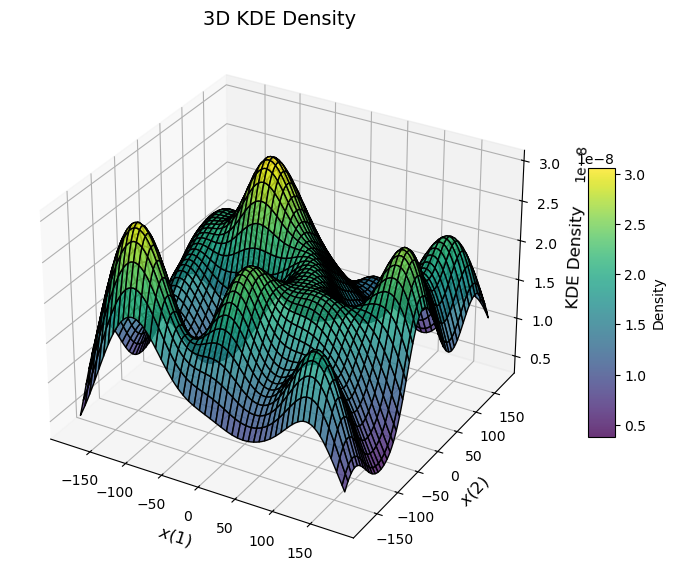

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KernelDensity

def plot_3d_density(data, kde_model, grid_size=50, cmap="viridis"):
    """
    Visualize the 3D KDE density as a surface plot.

    PARAMETERS
    ----------
        data: np.ndarray
            Nx3 array of 3D data points (angles).
        kde_model: sklearn.neighbors.KernelDensity
            Fitted KernelDensity object.
        grid_size: int
            Number of points along each axis for KDE evaluation.
        cmap: str
            Colormap for the surface plot.
    """
    # Extract data ranges for the grid
    x_min, x_max = data[:, 0].min(), data[:, 0].max()
    y_min, y_max = data[:, 1].min(), data[:, 1].max()
    z_min, z_max = data[:, 2].min(), data[:, 2].max()
    
    # Create a grid for KDE evaluation
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
    grid_points = np.c_[x_mesh.ravel(), y_mesh.ravel()]

    # Assume a fixed z value (e.g., mean of the z-dimension)
    z_fixed = np.mean(data[:, 2])
    grid_points = np.c_[grid_points, np.full(grid_points.shape[0], z_fixed)]

    # Evaluate KDE on the grid
    log_density = kde_model.score_samples(grid_points)
    density = np.exp(log_density).reshape(x_mesh.shape)
    
    # Set up the 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the density as a surface
    surface = ax.plot_surface(
        x_mesh, y_mesh, density, cmap=cmap, edgecolor='k', alpha=0.8
    )
    
    # Customize the axes and labels
    ax.set_xlabel(r"$x(1)$", fontsize=12)
    ax.set_ylabel(r"$x(2)$", fontsize=12)
    ax.set_zlabel(r"KDE Density", fontsize=12)
    ax.set_title("3D KDE Density", fontsize=14)
    fig.colorbar(surface, shrink=0.5, aspect=10, label="Density")
    
    plt.show()

# Example Usage
# Generate synthetic 3D data (replace with your data)
data = np.random.rand(500, 3) * 360 - 180  # Angles between -180 and 180

# Fit KDE to the data
kde = KernelDensity(kernel='gaussian', bandwidth=30).fit(data)

# Plot the KDE density
plot_3d_density(data, kde, grid_size=100, cmap="viridis")


In [172]:
def project_kde_to_2d(kde, pair_indices, fixed_range=(-180, 180), grid_size=100):
    """
    Project a 3D KDE onto a 2D plane by marginalizing over the third dimension.

    PARAMETERS
    ----------
        kde: Fitted KernelDensity object
        pair_indices: Tuple of indices to keep, e.g., (0, 1) for (phi, psi)
        fixed_range: Range of values for the marginalized dimension
        grid_size: Number of points in each grid dimension

    RETURNS
    -------
        grid_x, grid_y, marginalized_density: Grid points and 2D density values
    """
    # Generate 2D grid for the selected angle pair
    grid_x, grid_y = np.meshgrid(
        np.linspace(-180, 180, grid_size),
        np.linspace(-180, 180, grid_size)
    )
    grid_points = np.vstack([grid_x.ravel(), grid_y.ravel()]).T

    # Add a fine sampling over the marginalized dimension
    marginalized_axis = [i for i in range(3) if i not in pair_indices][0]
    marginalized_values = np.linspace(fixed_range[0], fixed_range[1], grid_size)

    # Prepare points for KDE evaluation
    expanded_points = []
    for value in marginalized_values:
        temp_points = np.zeros((grid_points.shape[0], 3))
        temp_points[:, pair_indices[0]] = grid_points[:, 0]
        temp_points[:, pair_indices[1]] = grid_points[:, 1]
        temp_points[:, marginalized_axis] = value
        expanded_points.append(temp_points)

    expanded_points = np.vstack(expanded_points)

    # Evaluate the density for all points
    log_density = kde.score_samples(expanded_points)
    density = np.exp(log_density)

    # Reshape to integrate over the marginalized dimension
    density = density.reshape(grid_size, grid_size, -1)
    marginalized_density = np.mean(density, axis=2)

    return grid_x, grid_y, marginalized_density


In [ ]:
# Get angles array
x_angle = "pseudo_phi"
y_angle = "pseudo_omega"

cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
angles = df[cond1 & cond2 & cond3][[x_angle, y_angle]].to_numpy()

kde = KernelDensity(bandwidth=10).fit(angles)

x = np.linspace(-180, 180, 100)
y = np.linspace(-180, 180, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE on the grid
density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

# Plot the KDE contours
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, density, levels=10, cmap="binary")

# Overlay scatter plot
sns.scatterplot(
    data=df[cond1 & cond2],
    x=x_angle,
    y=y_angle, 
    hue="Bad rotamer",
)

# Overlay the threshold contour
log_densities_high_quality = kde.score_samples(angles)
threshold = np.percentile(np.exp(log_densities_high_quality), 5)
plt.contour(x, y, density, levels=[threshold], colors="red", linewidths=1, linestyles="--")

# Set axis limits
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.legend(loc="lower left")
plt.show()

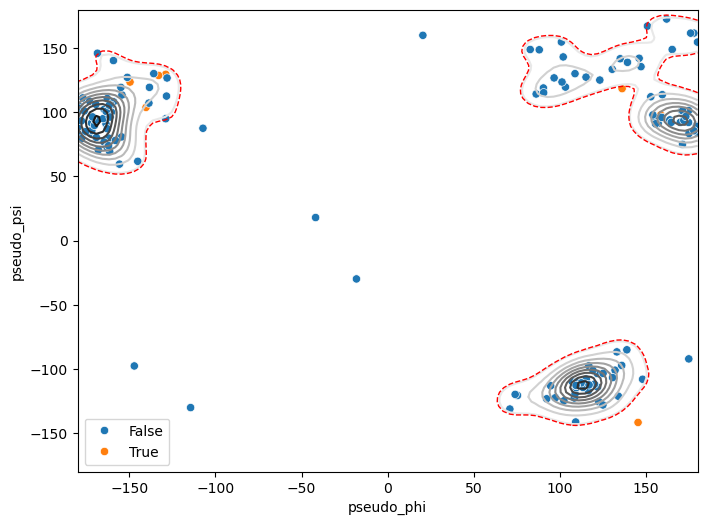

In [131]:
# Get angles array
x_angle = "pseudo_phi"
y_angle = "pseudo_psi"

cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
angles = df[cond1 & cond2 & cond3][[x_angle, y_angle]].to_numpy()

kde = KernelDensity(bandwidth=10).fit(angles)

x = np.linspace(-180, 180, 100)
y = np.linspace(-180, 180, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE on the grid
density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

# Plot the KDE contours
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, density, levels=10, cmap="binary")

# Overlay scatter plot
sns.scatterplot(
    data=df[cond1 & cond2],
    x=x_angle,
    y=y_angle, 
    hue="Bad rotamer",
)

# Overlay the threshold contour
log_densities_high_quality = kde.score_samples(angles)
threshold = np.percentile(np.exp(log_densities_high_quality), 5)
plt.contour(x, y, density, levels=[threshold], colors="red", linewidths=1, linestyles="--")

# Set axis limits
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.legend(loc="lower left")
plt.show()

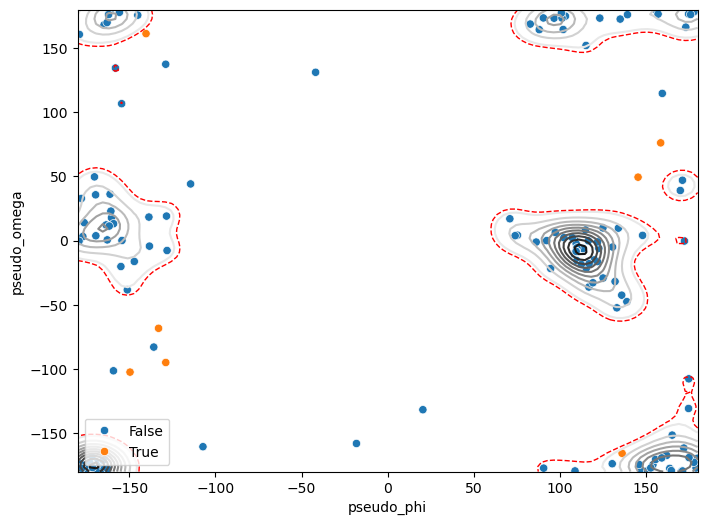

In [132]:
# Get angles array
x_angle = "pseudo_phi"
y_angle = "pseudo_omega"

cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
angles = df[cond1 & cond2 & cond3][[x_angle, y_angle]].to_numpy()

kde = KernelDensity(bandwidth=10).fit(angles)

x = np.linspace(-180, 180, 100)
y = np.linspace(-180, 180, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE on the grid
density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

# Plot the KDE contours
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, density, levels=10, cmap="binary")

# Overlay scatter plot
sns.scatterplot(
    data=df[cond1 & cond2],
    x=x_angle,
    y=y_angle, 
    hue="Bad rotamer",
)

# Overlay the threshold contour
log_densities_high_quality = kde.score_samples(angles)
threshold = np.percentile(np.exp(log_densities_high_quality), 5)
plt.contour(x, y, density, levels=[threshold], colors="red", linewidths=1, linestyles="--")

# Set axis limits
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.legend(loc="lower left")
plt.show()

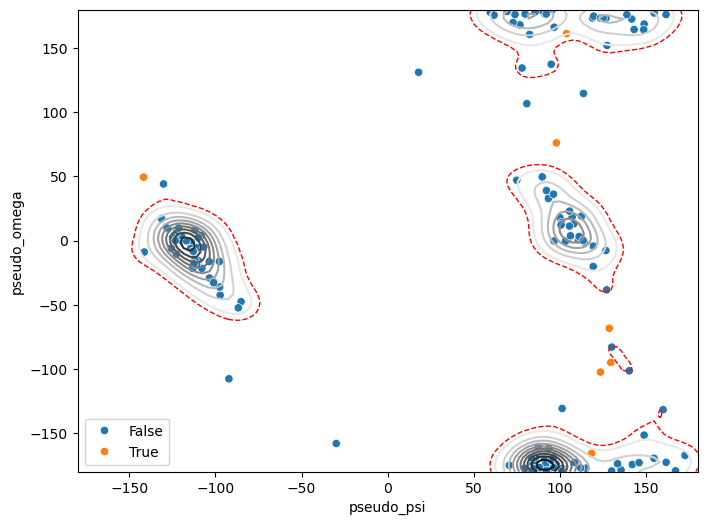

In [133]:
# Get angles array
x_angle = "pseudo_psi"
y_angle = "pseudo_omega"

cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
angles = df[cond1 & cond2 & cond3][[x_angle, y_angle]].to_numpy()

kde = KernelDensity(bandwidth=10).fit(angles)

x = np.linspace(-180, 180, 100)
y = np.linspace(-180, 180, 100)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Evaluate KDE on the grid
density = np.exp(kde.score_samples(grid_points)).reshape(X.shape)

# Plot the KDE contours
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, density, levels=10, cmap="binary")

# Overlay scatter plot
sns.scatterplot(
    data=df[cond1 & cond2],
    x=x_angle,
    y=y_angle, 
    hue="Bad rotamer",
)

# Overlay the threshold contour
log_densities_high_quality = kde.score_samples(angles)
threshold = np.percentile(np.exp(log_densities_high_quality), 5)
plt.contour(x, y, density, levels=[threshold], colors="red", linewidths=1, linestyles="--")

# Set axis limits
plt.xlim([-180, 180])
plt.ylim([-180, 180])
plt.legend(loc="lower left")
plt.show()

In [59]:
# Project onto bidimensional axis
# Something is clearly off

(-180.0, 180.0)

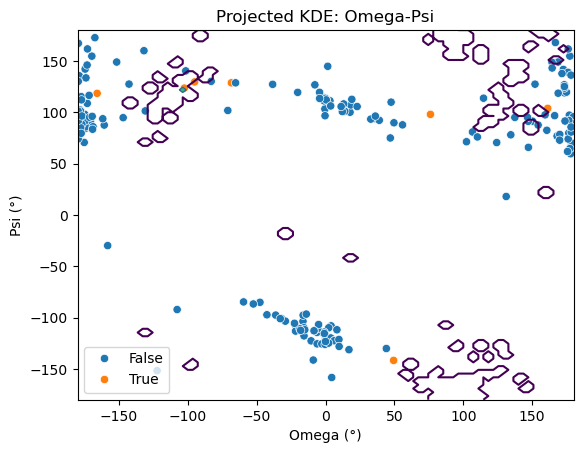

In [62]:
grid_x, grid_y, density = project_kde_to_2d(kde, pair_indices=(2, 1))

plt.contour(grid_x, grid_y, density, levels=2)
plt.title("Projected KDE: Omega-Psi")
plt.xlabel("Omega (°)")
plt.ylabel("Psi (°)")
g = sns.scatterplot( df[(df["Is bonded"])], 
    y="pseudo_psi", x="pseudo_omega", hue="Bad rotamer")
g.legend(loc="lower left")
plt.xlim([-180, 180])
plt.ylim([-180, 180])


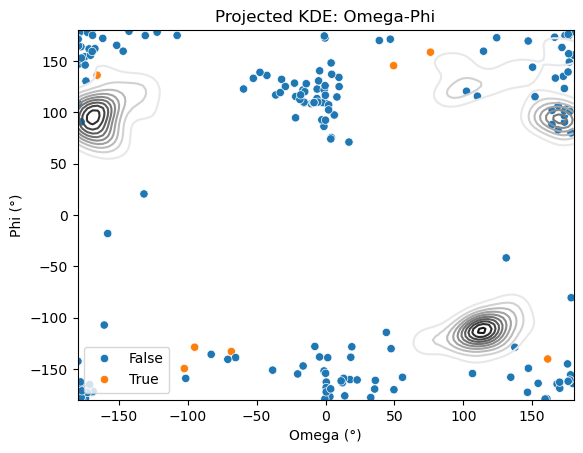

In [26]:
grid_x, grid_y, density = project_kde_to_2d(kde, pair_indices=(2, 0))

plt.contour(grid_x, grid_y, density, levels=10, cmap="binary")
plt.title("Projected KDE: Omega-Phi")
plt.xlabel("Omega (°)")
plt.ylabel("Phi (°)")
g = sns.scatterplot( df[(df["Is bonded"])], 
    y="pseudo_phi", x="pseudo_omega", hue="Bad rotamer")
g.legend(loc="lower left")

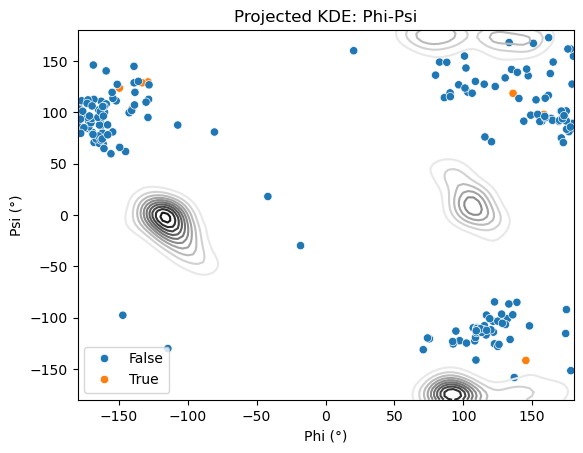

In [27]:
grid_x, grid_y, density = project_kde_to_2d(kde, pair_indices=(0, 1))

plt.contour(grid_x, grid_y, density, levels=10, cmap="binary")
plt.title("Projected KDE: Phi-Psi")
plt.xlabel("Phi (°)")
plt.ylabel("Psi (°)")
g = sns.scatterplot( df[(df["Is bonded"])], 
    y="pseudo_psi", x="pseudo_phi", hue="Bad rotamer")
g.legend(loc="lower left")

In [39]:
# Fit KDE on all three angles
# Get angles array
cond1 = (df["Is bonded"])
cond2 = (df["resolution"]<=2.5)
cond3 = (~df["Bad rotamer"])
angles = df[cond1 & cond2 & cond3][['pseudo_psi', 'pseudo_omega',]].to_numpy()

kde = KernelDensity(kernel="gaussian", bandwidth=.1).fit(angles)

In [40]:
cond1 = (df["Is bonded"])
cond2 = (~df["Bad rotamer"])
cond3 = (df["resolution"]<=2.5)
angles = df[cond1 & cond2 & cond3][['pseudo_psi', 'pseudo_omega',]].to_numpy()
kde.score_samples(angles)

array([-2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -1.65920888, -2.20252018, -2.20252018, -2.20252018, -2.20252018,
       -2.20252018, -2.20252018, -2.20252018, -2.20252018, -2.20

In [44]:
-2.88084244)

0.056087492578504476

array([[119.47546318, -20.17597991]])

In [53]:
np.exp(kde.score_samples(kde.sample(50)))

array([0.03593452, 0.07250186, 0.01817128, 0.10983598, 0.09173482,
       0.05790901, 0.00393862, 0.02651838, 0.17626337, 0.13469045,
       0.02216978, 0.0124879 , 0.08794902, 0.00282321, 0.0474089 ,
       0.10694926, 0.04980588, 0.06600467, 0.05016087, 0.04217041,
       0.09938941, 0.07885646, 0.06060328, 0.07209987, 0.10503585,
       0.05610481, 0.09896572, 0.03728249, 0.05098947, 0.03785206,
       0.06839126, 0.08606762, 0.07273648, 0.11019374, 0.09344338,
       0.02339128, 0.06176992, 0.06666694, 0.10099383, 0.02424361,
       0.04175132, 0.00363955, 0.00996479, 0.00483279, 0.09475464,
       0.0817623 , 0.10629927, 0.0279529 , 0.106348  , 0.08600958])

In [27]:
# Score
cond1 = (df["Is bonded"])
cond2 = (df["Bad rotamer"])
angles = df[cond1 & cond2][['pseudo_phi', 'pseudo_psi', 'pseudo_omega',]].to_numpy()

kde.score_samples(angles)

array([-15.51370549, -15.58764103, -15.74699378, -18.34753366,
       -21.46397121, -16.24167299, -24.65219095])

In [33]:
cond1 = (df["Is bonded"])
cond2 = (~df["Bad rotamer"])
cond3 = (df["resolution"]<=2.5)
angles = df[cond1 & cond2 & cond3][['pseudo_phi', 'pseudo_psi', 'pseudo_omega',]].to_numpy()
kde.score_samples(angles)

array([-14.63438408, -12.55196932, -12.9774866 , -14.34820264,
       -14.09381762, -13.17119127, -13.08111019, -13.15844746,
       -13.23009939, -13.85552176, -12.35121924, -13.77034262,
       -12.59634689, -12.23673245, -12.56129012, -14.03143462,
       -13.34391015, -12.55763947, -13.1646882 , -14.63438418,
       -12.74685834, -12.36958779, -13.93437481, -13.90474892,
       -12.59576248, -13.78364115, -13.36402901, -13.95913594,
       -14.53320584, -14.63438418, -14.62784215, -13.97470146,
       -13.68568215, -13.19166112, -13.73516316, -12.85753104,
       -13.27590957, -13.19670283, -13.91530897, -13.2257814 ,
       -13.66316087, -13.71298495, -12.56538557, -12.64521141,
       -14.63102076, -14.43357717, -13.94464951, -14.24272125,
       -12.40825957, -12.6489048 , -13.36879989, -13.63381909,
       -14.63438418, -13.44292333, -14.63400516, -12.18430944,
       -12.87183535, -12.25846042, -12.7200475 , -13.27414214,
       -13.10810276, -13.50141007, -14.63438418, -12.45

In [40]:
df[cond1 & cond2 & cond3]

,PDB code,Chain,UniProt Id,Species,Name,Position 1\r\n(Bond 1),Residue 1,Position 2\r\n(catalytic),Residue 2,Position 3\r\n(Bond 2),...,rASA,bond_length,aro,distance_to_aro,angle_with_aro,pseudo_omega,pseudo_psi,pseudo_phi,lys_x3,lys_x4
7,2x5p,A,Q8G9G1,Streptococcus pyogenes,fba2,31,K,77,E,117,...,"[0.024321874321960823, 0.01887826421826156, 0....",1.248426,TYR,6.782298,123.526940,-160.615204,87.527173,-107.254959,-52.027989,-107.254959
12,8jl8,A,NaN,Streptococcus mutans,Cnm,176,K,209,D,290,...,"[0.0355725125568669, 0.0016588226783495008, 0.0]",1.314587,TRP,5.115453,116.442900,-10.466968,-122.658586,108.349408,178.909538,108.349408
13,1amx,A,Q53654,Staphylococcus aureus,Cna,176,K,209,D,293,...,"[0.043874214189808546, 0.0, 0.0]",1.321738,TRP,4.965559,113.455734,-6.087789,-125.583423,122.609655,158.640433,122.609655
14,2f68,X,Q53654,Staphylococcus aureus,Cna,176,K,209,D,293,...,"[0.04271330368228075, 0.0, 0.0]",1.566506,TRP,5.043070,111.851074,4.060007,-108.055300,148.026510,128.379020,148.026510
16,2okm,A,Q9F865,Enterococcus faecalis,ACE,42,K,74,D,155,...,"[0.03280570739653052, 0.02317977207569988, 0.0...",1.324288,TRP,5.112070,120.484120,-8.891113,-141.362704,109.167986,179.731374,109.167986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,4oq1,A,A0A0H2UNM0,Streptococcus pneumoniae TIGR4,SP_0464,264,K,322,E,354,...,"[0.0, 0.0801347875103508, 0.005166650957362667]",1.136266,TYR,6.376158,136.181600,166.293851,96.708150,173.109410,79.472673,173.109410
186,6m48,A,NaN,Lacticaseibacillus rhamnosus GG,SpaC,108,K,395,D,470,...,"[0.018497500768521937, 0.004904677348634217, 0...",1.288734,TYR,7.050498,95.757440,176.148898,161.642765,175.912369,-154.234564,175.912369
187,6m48,A,NaN,Lacticaseibacillus rhamnosus GG,SpaC,604,K,658,E,729,...,"[0.1187183926745159, 0.007712694173006667, 0.0...",1.328592,PHE,7.353461,151.368230,134.464473,78.041120,-158.058582,105.005320,-158.058582
188,6m48,A,NaN,Lacticaseibacillus rhamnosus GG,SpaC,502,K,568,E,595,...,"[0.024086926332334193, 0.7843835679526182, 0.0...",1.266411,TRP,3.946533,25.898287,-179.488970,130.078303,108.778822,81.403226,108.778822
